In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor

In [2]:
class MakeClass(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        uniques = torch.unique(x, sorted = True)
        for i, v in enumerate(uniques):
            x[x == v] = i
        return x.to(dtype=torch.long)

In [3]:
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

target_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(), 
        MakeClass()
    ]
)

train_ds = OxfordIIITPet(
    root = "~/data", split = "trainval", target_types = "segmentation", transform = transform, 
    target_transform = target_transform, 
    download = True
)

test_ds = OxfordIIITPet(
    root = "~/data", split = "test", target_types = "segmentation", transform = transform, 
    target_transform = target_transform, 
    download = True
)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, pin_memory = True, num_workers=24)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=True, pin_memory = True, num_workers=24)

print("#Training Samples: {}".format(len(train_ds)))
print("#Testing Samples: {}".format(len(test_ds)))
print("#Training Batch: {}".format(len(train_dl)))
print("#Testing Batch: {}".format(len(test_dl)))

#Training Samples: 3680
#Testing Samples: 3669
#Training Batch: 58
#Testing Batch: 58


In [4]:
sample_data, sample_mask = train_ds[100]

print(f"data shape: {sample_data.shape}")
print(f"mask shape: {sample_mask.shape}")

print(f"Number classes: {np.unique(sample_mask.numpy())}")

data shape: torch.Size([3, 256, 256])
mask shape: torch.Size([1, 256, 256])
Number classes: [0 1 2]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


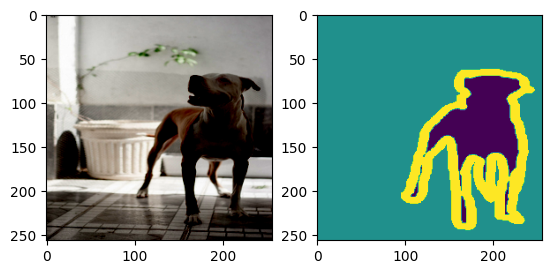

In [5]:
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(sample_data.cpu().permute(1, -1, 0).numpy())
axarr[1].imshow(sample_mask.cpu().permute(1, -1, 0).numpy())

In [6]:
class Attention_block(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out

In [7]:
class Recurrent_block(nn.Module):
    def __init__(self, out_ch, t=2):
        super(Recurrent_block, self).__init__()

        self.t = t
        self.out_ch = out_ch
        self.conv = nn.Sequential(
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        for i in range(self.t):
            if i == 0:
                x = self.conv(x)
            out = self.conv(x + x)
        return out


class RRCNN_block(nn.Module):
    def __init__(self, in_ch, out_ch, t=2):
        super(RRCNN_block, self).__init__()

        self.RCNN = nn.Sequential(
            Recurrent_block(out_ch, t=t),
            Recurrent_block(out_ch, t=t)
        )
        self.Conv = nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x1 = self.Conv(x)
        x2 = self.RCNN(x1)
        out = x1 + x2
        return out

class up_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

In [8]:
class R2AttU_Net(nn.Module):
    def __init__(self, in_ch=3, out_ch=3, t=2, init_channels = 16):
        super(R2AttU_Net, self).__init__()

        n1 = init_channels
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.RRCNN1 = RRCNN_block(in_ch, filters[0], t=t)
        self.RRCNN2 = RRCNN_block(filters[0], filters[1], t=t)
        self.RRCNN3 = RRCNN_block(filters[1], filters[2], t=t)
        self.RRCNN4 = RRCNN_block(filters[2], filters[3], t=t)
        self.RRCNN5 = RRCNN_block(filters[3], filters[4], t=t)

        self.Up5 = up_conv(filters[4], filters[3])
        self.Att5 = Attention_block(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.Up_RRCNN5 = RRCNN_block(filters[4], filters[3], t=t)

        self.Up4 = up_conv(filters[3], filters[2])
        self.Att4 = Attention_block(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.Up_RRCNN4 = RRCNN_block(filters[3], filters[2], t=t)

        self.Up3 = up_conv(filters[2], filters[1])
        self.Att3 = Attention_block(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.Up_RRCNN3 = RRCNN_block(filters[2], filters[1], t=t)

        self.Up2 = up_conv(filters[1], filters[0])
        self.Att2 = Attention_block(F_g=filters[0], F_l=filters[0], F_int=32)
        self.Up_RRCNN2 = RRCNN_block(filters[1], filters[0], t=t)

        self.Conv = nn.Conv2d(filters[0], out_ch, kernel_size=1, stride=1, padding=0)


    def forward(self, x):

        e1 = self.RRCNN1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.RRCNN2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.RRCNN3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.RRCNN4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.RRCNN5(e5)

        d5 = self.Up5(e5)
        e4 = self.Att5(g=d5, x=e4)
        d5 = torch.cat((e4, d5), dim=1)
        d5 = self.Up_RRCNN5(d5)

        d4 = self.Up4(d5)
        e3 = self.Att4(g=d4, x=e3)
        d4 = torch.cat((e3, d4), dim=1)
        d4 = self.Up_RRCNN4(d4)

        d3 = self.Up3(d4)
        e2 = self.Att3(g=d3, x=e2)
        d3 = torch.cat((e2, d3), dim=1)
        d3 = self.Up_RRCNN3(d3)

        d2 = self.Up2(d3)
        e1 = self.Att2(g=d2, x=e1)
        d2 = torch.cat((e1, d2), dim=1)
        d2 = self.Up_RRCNN2(d2)

        out = self.Conv(d2)

        return out

In [9]:
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = R2AttU_Net().to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

scheduler = CosineAnnealingLR(optimizer, epochs * len(train_dl))

loss_fn = nn.CrossEntropyLoss()

In [11]:
old_loss = 1e26
best_dct = None
last_dst = None
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    for train_img, train_mask in tqdm(train_dl):
        train_img = train_img.to(device)
        train_mask = train_mask.to(device, dtype = torch.long)

        train_gen_mask = model(train_img)
        train_rec_loss = loss_fn(train_gen_mask, train_mask.squeeze(1))
        train_dice_loss = dice_loss(
            F.softmax(train_gen_mask, dim=1).float(),
            F.one_hot(train_mask.squeeze(1), 3).permute(0, 3, 1, 2).float(),
            multiclass=True
        )
        train_loss = train_rec_loss + train_dice_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_total_loss += train_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = 0
        for valid_img, valid_mask in tqdm(test_dl):
            valid_img = valid_img.to(device)
            valid_mask = valid_mask.to(device, dtype = torch.long)
            
            valid_gen_mask = model(valid_img)
            valid_loss = loss_fn(valid_gen_mask, valid_mask.squeeze(1))
            valid_dice_loss = dice_loss(
                F.softmax(valid_gen_mask, dim=1).float(),
                F.one_hot(valid_mask.squeeze(1), 3).permute(0, 3, 1, 2).float(),
                multiclass=True
            )
            valid_loss = train_rec_loss + train_dice_loss

            va_total_loss += valid_loss.item()
            
    mean_train_loss = tr_total_loss/len(train_dl)
    mean_valid_loss = va_total_loss/len(test_dl)

    if mean_valid_loss <= old_loss:
        old_loss = mean_valid_loss
        best_dct = model.state_dict()
    
    last_dct = model.state_dict()

    print(f"Epoch: {epoch} - TrainLoss: {mean_train_loss} - ValidLoss: {mean_valid_loss}")
model.load_state_dict(best_dct)

100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.95it/s]


Epoch: 0 - TrainLoss: 1.1711286008358002 - ValidLoss: 0.8894941806793213


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.93it/s]


Epoch: 1 - TrainLoss: 0.8304749449779247 - ValidLoss: 0.6832195520401001


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.87it/s]


Epoch: 2 - TrainLoss: 0.699050567273436 - ValidLoss: 0.6263955235481262


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.92it/s]


Epoch: 3 - TrainLoss: 0.642509812938756 - ValidLoss: 0.554216742515564


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.93it/s]


Epoch: 4 - TrainLoss: 0.5970436889549782 - ValidLoss: 0.7449779510498047


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.98it/s]


Epoch: 5 - TrainLoss: 0.5632292849236521 - ValidLoss: 0.5358584523200989


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.98it/s]


Epoch: 6 - TrainLoss: 0.5352671500937692 - ValidLoss: 0.6135836839675903


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.89it/s]


Epoch: 7 - TrainLoss: 0.5119767250685856 - ValidLoss: 0.5549376010894775


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.90it/s]


Epoch: 8 - TrainLoss: 0.4991999741258292 - ValidLoss: 0.630896270275116


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.92it/s]


Epoch: 9 - TrainLoss: 0.47318114648605214 - ValidLoss: 0.4609143137931824


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.94it/s]


Epoch: 10 - TrainLoss: 0.453728124499321 - ValidLoss: 0.4635463356971741


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.92it/s]


Epoch: 11 - TrainLoss: 0.4420244010358021 - ValidLoss: 0.44134172797203064


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.88it/s]


Epoch: 12 - TrainLoss: 0.4320114624911341 - ValidLoss: 0.37197166681289673


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.92it/s]


Epoch: 13 - TrainLoss: 0.41813188328825196 - ValidLoss: 0.3916611075401306


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.87it/s]


Epoch: 14 - TrainLoss: 0.4115838685940052 - ValidLoss: 0.3667662739753723


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.86it/s]


Epoch: 15 - TrainLoss: 0.386308207080282 - ValidLoss: 0.3595426082611084


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.90it/s]


Epoch: 16 - TrainLoss: 0.38603719914781637 - ValidLoss: 0.3580411672592163


100%|██████████████████████████████████████████████████████| 58/58 [00:12<00:00,  4.83it/s]


Epoch: 17 - TrainLoss: 0.3703104807385083 - ValidLoss: 0.36112505197525024


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.88it/s]


Epoch: 18 - TrainLoss: 0.3621768668807786 - ValidLoss: 0.33581459522247314


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.91it/s]


Epoch: 19 - TrainLoss: 0.36308915604805125 - ValidLoss: 0.3270311951637268


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.90it/s]


Epoch: 20 - TrainLoss: 0.3577851329384179 - ValidLoss: 0.35367053747177124


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.95it/s]


Epoch: 21 - TrainLoss: 0.3364580175999937 - ValidLoss: 0.2904718518257141


100%|██████████████████████████████████████████████████████| 58/58 [00:12<00:00,  4.83it/s]


Epoch: 22 - TrainLoss: 0.32682309582315644 - ValidLoss: 0.3916788101196289


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.93it/s]


Epoch: 23 - TrainLoss: 0.32340401102756633 - ValidLoss: 0.4393242597579956


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.87it/s]


Epoch: 24 - TrainLoss: 0.31713198844728796 - ValidLoss: 0.34180545806884766


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.94it/s]


Epoch: 25 - TrainLoss: 0.3156867977874032 - ValidLoss: 0.4251464009284973


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.93it/s]


Epoch: 26 - TrainLoss: 0.3129336839092189 - ValidLoss: 0.29547375440597534


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.90it/s]


Epoch: 27 - TrainLoss: 0.29008358896806324 - ValidLoss: 0.28365427255630493


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.93it/s]


Epoch: 28 - TrainLoss: 0.29406685561969365 - ValidLoss: 0.28628799319267273


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.87it/s]


Epoch: 29 - TrainLoss: 0.2905568174760917 - ValidLoss: 0.3226543366909027


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.86it/s]


Epoch: 30 - TrainLoss: 0.2957908436655998 - ValidLoss: 0.2897404134273529


100%|██████████████████████████████████████████████████████| 58/58 [00:12<00:00,  4.82it/s]


Epoch: 31 - TrainLoss: 0.28370432170300647 - ValidLoss: 0.27786511182785034


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.90it/s]


Epoch: 32 - TrainLoss: 0.26758680749556113 - ValidLoss: 0.2659991383552551


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.94it/s]


Epoch: 33 - TrainLoss: 0.2518214336757002 - ValidLoss: 0.24529333412647247


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.87it/s]


Epoch: 34 - TrainLoss: 0.24958698579977298 - ValidLoss: 0.2737356424331665


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.87it/s]


Epoch: 35 - TrainLoss: 0.2446445046827711 - ValidLoss: 0.25289949774742126


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.89it/s]


Epoch: 36 - TrainLoss: 0.24151044338941574 - ValidLoss: 0.229363352060318


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.90it/s]


Epoch: 37 - TrainLoss: 0.2305602572601417 - ValidLoss: 0.22441130876541138


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.86it/s]


Epoch: 38 - TrainLoss: 0.22468569232472058 - ValidLoss: 0.24026377499103546


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.87it/s]


Epoch: 39 - TrainLoss: 0.22743552332294398 - ValidLoss: 0.25826120376586914


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.89it/s]


Epoch: 40 - TrainLoss: 0.22913976039352088 - ValidLoss: 0.20807640254497528


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.94it/s]


Epoch: 41 - TrainLoss: 0.23120942994438368 - ValidLoss: 0.2326086163520813


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.91it/s]


Epoch: 42 - TrainLoss: 0.24003748904014455 - ValidLoss: 0.25138038396835327


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.86it/s]


Epoch: 43 - TrainLoss: 0.22183913506310562 - ValidLoss: 0.1957702785730362


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.86it/s]


Epoch: 44 - TrainLoss: 0.23552331611000257 - ValidLoss: 0.2531857192516327


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.90it/s]


Epoch: 45 - TrainLoss: 0.22046802270001378 - ValidLoss: 0.21480737626552582


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.89it/s]


Epoch: 46 - TrainLoss: 0.20445670572848157 - ValidLoss: 0.18984468281269073


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.90it/s]


Epoch: 47 - TrainLoss: 0.1979620731596289 - ValidLoss: 0.19809016585350037


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.88it/s]


Epoch: 48 - TrainLoss: 0.19286698077259393 - ValidLoss: 0.18599379062652588


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.84it/s]


Epoch: 49 - TrainLoss: 0.18854856234172296 - ValidLoss: 0.17627254128456116


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.95it/s]


Epoch: 50 - TrainLoss: 0.1879352292624013 - ValidLoss: 0.20212188363075256


100%|██████████████████████████████████████████████████████| 58/58 [00:12<00:00,  4.83it/s]


Epoch: 51 - TrainLoss: 0.18358423432399487 - ValidLoss: 0.17913517355918884


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.84it/s]


Epoch: 52 - TrainLoss: 0.18112919479608536 - ValidLoss: 0.18206286430358887


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.90it/s]


Epoch: 53 - TrainLoss: 0.17820843771613878 - ValidLoss: 0.19731073081493378


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.85it/s]


Epoch: 54 - TrainLoss: 0.17462544939641295 - ValidLoss: 0.1672777682542801


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.90it/s]


Epoch: 55 - TrainLoss: 0.1765819184225181 - ValidLoss: 0.185632586479187


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.90it/s]


Epoch: 56 - TrainLoss: 0.1732309614789897 - ValidLoss: 0.175375834107399


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.92it/s]


Epoch: 57 - TrainLoss: 0.16814618814608145 - ValidLoss: 0.17478322982788086


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.86it/s]


Epoch: 58 - TrainLoss: 0.1665983184658248 - ValidLoss: 0.16184908151626587


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.89it/s]


Epoch: 59 - TrainLoss: 0.16271919191911302 - ValidLoss: 0.15744638442993164


100%|██████████████████████████████████████████████████████| 58/58 [00:12<00:00,  4.83it/s]


Epoch: 60 - TrainLoss: 0.16044452452454075 - ValidLoss: 0.15639393031597137


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.91it/s]


Epoch: 61 - TrainLoss: 0.15735710309497242 - ValidLoss: 0.1554810106754303


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.86it/s]


Epoch: 62 - TrainLoss: 0.15555848951997428 - ValidLoss: 0.1717190444469452


100%|██████████████████████████████████████████████████████| 58/58 [00:12<00:00,  4.78it/s]


Epoch: 63 - TrainLoss: 0.15353072717272 - ValidLoss: 0.14903423190116882


100%|██████████████████████████████████████████████████████| 58/58 [00:12<00:00,  4.75it/s]


Epoch: 64 - TrainLoss: 0.1513595550224699 - ValidLoss: 0.15890643000602722


100%|██████████████████████████████████████████████████████| 58/58 [00:12<00:00,  4.78it/s]


Epoch: 65 - TrainLoss: 0.14848629410924583 - ValidLoss: 0.15074247121810913


100%|██████████████████████████████████████████████████████| 58/58 [00:12<00:00,  4.81it/s]


Epoch: 66 - TrainLoss: 0.1471332321906912 - ValidLoss: 0.15847115218639374


100%|██████████████████████████████████████████████████████| 58/58 [00:12<00:00,  4.76it/s]


Epoch: 67 - TrainLoss: 0.14458134282251883 - ValidLoss: 0.14868983626365662


100%|██████████████████████████████████████████████████████| 58/58 [00:12<00:00,  4.79it/s]


Epoch: 68 - TrainLoss: 0.14242009895628896 - ValidLoss: 0.14113624393939972


100%|██████████████████████████████████████████████████████| 58/58 [00:12<00:00,  4.57it/s]


Epoch: 69 - TrainLoss: 0.1406322799879929 - ValidLoss: 0.1452063024044037


100%|██████████████████████████████████████████████████████| 58/58 [00:12<00:00,  4.60it/s]


Epoch: 70 - TrainLoss: 0.13802347794688982 - ValidLoss: 0.13217663764953613


100%|██████████████████████████████████████████████████████| 58/58 [00:12<00:00,  4.66it/s]


Epoch: 71 - TrainLoss: 0.13654584540375347 - ValidLoss: 0.1381157636642456


100%|██████████████████████████████████████████████████████| 58/58 [00:12<00:00,  4.79it/s]


Epoch: 72 - TrainLoss: 0.1340013698771082 - ValidLoss: 0.13159137964248657


100%|██████████████████████████████████████████████████████| 58/58 [00:12<00:00,  4.82it/s]


Epoch: 73 - TrainLoss: 0.13307704403996468 - ValidLoss: 0.12962380051612854


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.84it/s]


Epoch: 74 - TrainLoss: 0.13091885375565496 - ValidLoss: 0.12285646796226501


100%|██████████████████████████████████████████████████████| 58/58 [00:12<00:00,  4.80it/s]


Epoch: 75 - TrainLoss: 0.13042974484891728 - ValidLoss: 0.12986308336257935


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.87it/s]


Epoch: 76 - TrainLoss: 0.12834780059497933 - ValidLoss: 0.1382783055305481


100%|██████████████████████████████████████████████████████| 58/58 [00:12<00:00,  4.83it/s]


Epoch: 77 - TrainLoss: 0.1271812778351636 - ValidLoss: 0.128016397356987


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.89it/s]


Epoch: 78 - TrainLoss: 0.12553254964536634 - ValidLoss: 0.12635816633701324


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.94it/s]


Epoch: 79 - TrainLoss: 0.12366939824202965 - ValidLoss: 0.13295194506645203


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.89it/s]


Epoch: 80 - TrainLoss: 0.12259369497669154 - ValidLoss: 0.12814274430274963


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.85it/s]


Epoch: 81 - TrainLoss: 0.12241560130797584 - ValidLoss: 0.1215885803103447


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.90it/s]


Epoch: 82 - TrainLoss: 0.12096399890965429 - ValidLoss: 0.11664323508739471


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.87it/s]


Epoch: 83 - TrainLoss: 0.11994846049567749 - ValidLoss: 0.12399474531412125


100%|██████████████████████████████████████████████████████| 58/58 [00:12<00:00,  4.81it/s]


Epoch: 84 - TrainLoss: 0.119255309346421 - ValidLoss: 0.13402587175369263


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.84it/s]


Epoch: 85 - TrainLoss: 0.11878221392117698 - ValidLoss: 0.1284649521112442


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.91it/s]


Epoch: 86 - TrainLoss: 0.11714404089183643 - ValidLoss: 0.11241849511861801


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.84it/s]


Epoch: 87 - TrainLoss: 0.11703481872020097 - ValidLoss: 0.116175577044487


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.87it/s]


Epoch: 88 - TrainLoss: 0.11636617908190036 - ValidLoss: 0.12641923129558563


100%|██████████████████████████████████████████████████████| 58/58 [00:12<00:00,  4.81it/s]


Epoch: 89 - TrainLoss: 0.11542597284604764 - ValidLoss: 0.1225070059299469


100%|██████████████████████████████████████████████████████| 58/58 [00:12<00:00,  4.83it/s]


Epoch: 90 - TrainLoss: 0.11546011012175987 - ValidLoss: 0.1294325888156891


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.86it/s]


Epoch: 91 - TrainLoss: 0.11480314682783752 - ValidLoss: 0.11947428435087204


100%|██████████████████████████████████████████████████████| 58/58 [00:12<00:00,  4.83it/s]


Epoch: 92 - TrainLoss: 0.11416329700371315 - ValidLoss: 0.12080814689397812


100%|██████████████████████████████████████████████████████| 58/58 [00:12<00:00,  4.83it/s]


Epoch: 93 - TrainLoss: 0.11417593357378039 - ValidLoss: 0.11355135589838028


100%|██████████████████████████████████████████████████████| 58/58 [00:12<00:00,  4.81it/s]


Epoch: 94 - TrainLoss: 0.11445926759263565 - ValidLoss: 0.12325318157672882


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.88it/s]


Epoch: 95 - TrainLoss: 0.11357257219737973 - ValidLoss: 0.14102470874786377


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.85it/s]


Epoch: 96 - TrainLoss: 0.11411087459017491 - ValidLoss: 0.11783604323863983


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.89it/s]


Epoch: 97 - TrainLoss: 0.11365173821305406 - ValidLoss: 0.11307989060878754


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.91it/s]


Epoch: 98 - TrainLoss: 0.11367251004638343 - ValidLoss: 0.11043333262205124


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.87it/s]

Epoch: 99 - TrainLoss: 0.11329471165763921 - ValidLoss: 0.12191309034824371


<All keys matched successfully>

  0%|                                                               | 0/10 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 10%|█████▌                                                 | 1/10 [00:00<00:01,  8.22it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 30%|████████████████▌                                      | 3/10 [00:00<00:00, 12.72it/s]Clipping input data to the valid range for imshow with RGB data ([0

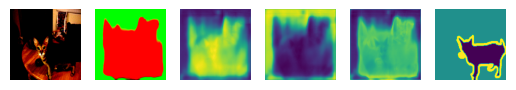

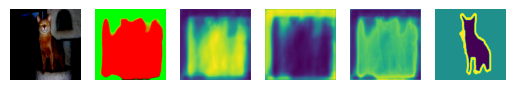

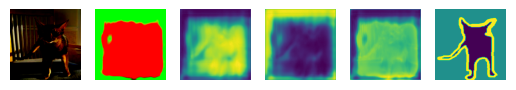

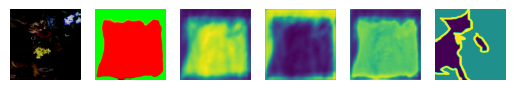

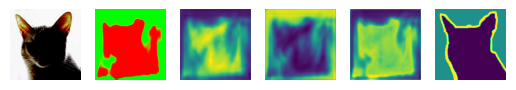

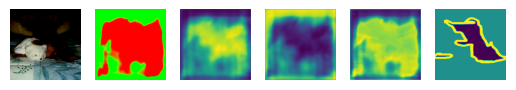

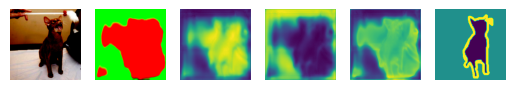

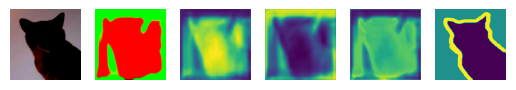

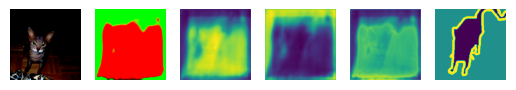

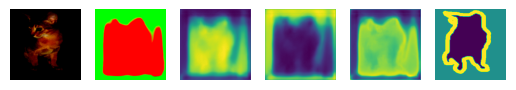

In [12]:
model.eval()
with torch.no_grad():
    for test_case_idx in tqdm(range(10)):
        valid_img, valid_mask = test_ds[test_case_idx]
        valid_img = valid_img.unsqueeze(dim=0).to(device)

        gen_mask = model(valid_img)     

        f, axarr = plt.subplots(1, 6)
        axarr[0].imshow(valid_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[0].axis('off')
        axarr[1].imshow(gen_mask[0].cpu().permute(1, -1, 0).numpy())
        axarr[1].axis('off')
        axarr[2].imshow(gen_mask[0][0].unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        axarr[2].axis('off')
        axarr[3].imshow(gen_mask[0][1].unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        axarr[3].axis('off')
        axarr[4].imshow(gen_mask[0][2].unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        axarr[4].axis('off')
        axarr[5].imshow(valid_mask.cpu().permute(1, -1, 0).numpy())
        axarr[5].axis('off')